In [294]:
import numpy as np
import matplotlib.pyplot as plt
from fourier import fourier_series_coeff
from parameters import *
from leading_order import c_tr_0, c_ci_0, gamma_tr_0, gamma_ci_0, Delta, A_0
from first_order import (
    form_equations, form_equations_o, form_inverse_equations, form_inverse_equations_o,
    psi_h, d_psi_h, c_h, psi_o, d_psi_o, c_o
)

In [295]:
from matplotlib import rc

font = {
    "family": "serif",
    "serif": ["Computer Modern"],
    "size": 12,
}

rc("font", **font)
rc("text", usetex=True)

In [296]:
# Numerical parameters
eps = 1e-12
N = 50
step = 5

In [297]:
# Light intensity
def f_1(x):
    """A 2L-periodic light intensity perturbation."""

    # Sine perturbation
    # return np.cos(np.pi * x / L) + np.sin(2 * np.pi * x / L)

    # Even perturbation
    return 0.5 * (np.tanh((x + 1) / delta) - np.tanh((x - 1) / delta))

    # Odd perturbation
    # return 0.5 / delta * (1 / np.cosh((x + 1) / delta)**2 - 1 / np.cosh((x - 1) / delta)**2)
    

In [298]:
# Surface shape
def S_1(x):
    """A 2L-periodic surface shape perturbation."""
    
    # Sine perturbation
    return np.cos(np.pi * x / L) + np.sin(2 * np.pi * x / L)

    # Even perturbation
    # return 0.5 * (np.tanh((x + 1) / delta) - np.tanh((x - 1) / delta))

## Fourier Setup

In [299]:
# Set the frequencies
omega_full = np.arange(-N, N + 1) * np.pi / L
omega = np.concatenate([omega_full[:N], omega_full[N + 1:]])  # Excluding the zero frequency

In [300]:
# Extract Fourier coefficients for the light intensity perturbation
f_coeffs = fourier_series_coeff(lambda x: f_1(x - L), 2 * L, N - 1, return_complex=True)

# General solution Fourier coefficients
f_coeffs = np.ones(N + 1, dtype=np.complex128)

f_o = f_coeffs[0]  # Zero mode
f_h = lambda x: np.concatenate([f_coeffs[1:][::-1].conj(), f_coeffs[1:]])  # Exclude the zero mode

f_full = lambda : np.concatenate([[f_o], f_h(omega)])

In [301]:
# Extract Fourier coefficients for the surface shape perturbation
S_coeffs = fourier_series_coeff(lambda x: S_1(x - L), 2 * L, N - 1, return_complex=True)

S_o = S_coeffs[0]  # Zero mode
S_h = lambda x: np.concatenate([S_coeffs[1:][::-1].conj(), S_coeffs[1:]])  # Exclude the zero mode

S_full = lambda : np.concatenate([[S_o], S_h(omega)])

if not abs(S_o) < eps:
    print("Warning: The zero mode of the surface shape perturbation is not zero.")
    print("Setting it to zero.")

S_o = 0

Setting it to zero.


## Leading Order

### Verify solutions to Leading Order

In [302]:
# Bulk concentrations
assert abs(c_tr_0(0.4) + eta * c_ci_0(0.4) - A_0) < eps

# Surface concentrations
assert abs((gamma_tr_0 + gamma_ci_0) - (1 - 1 / Delta)) < eps

### Solution Plots to Leading Order

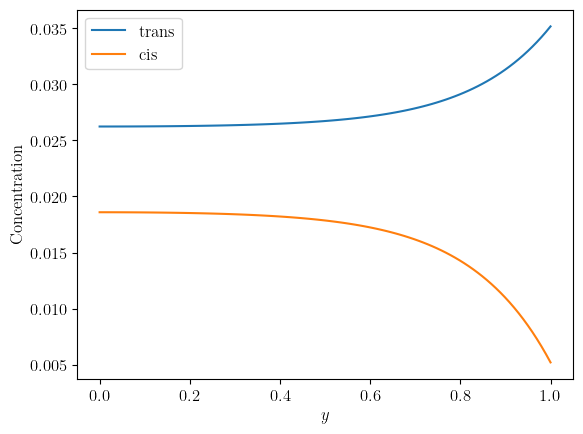

In [303]:
yy = np.linspace(0, 1, 100)

plt.plot(yy, c_tr_0(yy), label="trans")
plt.plot(yy, c_ci_0(yy), label="cis")
plt.xlabel(r"$y$")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## First Order

### Forward Problem

#### Solutions for Constants of Integration

In [304]:
# Form linear system for the unknowns
sys = form_equations(omega, f_h)
forcing = sys[:, -1, :]

sys_o = form_equations_o(f_o)[:, :, 0]
forcing_o = sys_o[:, -1]

In [305]:
# Compute unknowns
sols = np.array([np.linalg.solve(sys[:, :-1, i], -forcing[:, i]) for i in range(2 * N)])
sols_o = np.array([np.linalg.solve(sys_o[:, :-1], -forcing_o)])

#### Test Against Analytical Solutions

In [306]:
assert np.allclose(sols[:, 1], -(sols[:, 0] * np.sinh(omega)) / (np.sinh(omega) - omega * np.exp(-omega)))  # Check for B_h

In [307]:
# Constant mode
assert np.allclose(sols_o[0, :3], 0)  # psi_o = 0


In [308]:
"""
assert abs(sols_o[4]) < eps  # E_h = 0
assert abs(sols_o[6]) < eps  # G_h = 0
assert abs(sols_o[-1]) < eps  # S_h = 0
assert np.sum(J_o[:, :-1, 0] @ sols_o[:, np.newaxis] + J_o[:, -1, :]) < eps  # J_tr + J_ci = 0
assert np.allclose([
    np.dot((np.tensordot(U, d_p_o(y), axes=1)[:, :-1, 0] @ sols_o[:, np.newaxis]
            + np.tensordot(U, d_p_o(y), axes=1)[:, -1, :]).flatten(), np.array([1, eta]))
    for y in np.linspace(0, 1, 10)
], 0)  # d_c_tr + eta * d_c_ci = 0
"""

'\nassert abs(sols_o[4]) < eps  # E_h = 0\nassert abs(sols_o[6]) < eps  # G_h = 0\nassert abs(sols_o[-1]) < eps  # S_h = 0\nassert np.sum(J_o[:, :-1, 0] @ sols_o[:, np.newaxis] + J_o[:, -1, :]) < eps  # J_tr + J_ci = 0\nassert np.allclose([\n    np.dot((np.tensordot(U, d_p_o(y), axes=1)[:, :-1, 0] @ sols_o[:, np.newaxis]\n            + np.tensordot(U, d_p_o(y), axes=1)[:, -1, :]).flatten(), np.array([1, eta]))\n    for y in np.linspace(0, 1, 10)\n], 0)  # d_c_tr + eta * d_c_ci = 0\n'

#### Solutions

In [309]:
def psi_f(y):
    val_o = psi_o(y)
    val_h = psi_h(omega, y)
    return np.concatenate([
        np.einsum("ij,ji->i", sols_o, val_o[:-1]) + val_o[-1],
        np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1],
    ])

def u_f(y):
    val_o = d_psi_o(y)
    val_h = d_psi_h(omega, y)
    return np.concatenate([
        np.einsum("ij,ji->i", sols_o, val_o[:-1]) + val_o[-1, 0],
        np.einsum("ij,ji->i", sols, val_h[:-1] + val_h[-1]),
    ])

def v_f(y):
    val_h = psi_h(omega, y)
    return np.concatenate([
        [0],
        -1.j * omega * (np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1]),
    ])

def c_f(y):
    val_o = c_o(y)
    val_h = c_h(omega, y)
    return np.concatenate([
        np.einsum("ij,kji->ki", sols_o, val_o[:, :-1]) + val_o[:, -1],
        np.einsum("ij,kji->ki", sols, val_h[:, :-1]) + val_h[:, -1],
    ], axis=1)

def c_tr_f(y):
    return c_f(y)[0]

def c_ci_f(y):
    return c_f(y)[1]

def gamma_tr_f():
    return np.concatenate([
        sols_o[:, -3],
        sols[:, -6],
    ])

def gamma_ci_f():
    return np.concatenate([
        sols_o[:, -2],
        sols[:, -5],
    ])

def S_f():
    return np.concatenate([
        [0],
        sols[:, -3],
    ])

def f_f():
    return np.concatenate([
        sols_o[:, -1],
        sols[:, -4],
    ])

In [310]:
def invert(f):
    def _(x, *args):
        coeffs = f(*args)
        return coeffs[0] + np.sum(coeffs[1:, np.newaxis] * np.exp(1.j * omega[:, np.newaxis] * (x + L)[np.newaxis, :]), axis=0)

    return _

In [311]:
psi = invert(psi_f)
u = invert(u_f)
v = invert(v_f)
c_tr = invert(c_tr_f)
c_ci = invert(c_ci_f)
gamma_tr = invert(gamma_tr_f)
gamma_ci = invert(gamma_ci_f)
S_inv = invert(S_f)
f_inv = invert(f_f)

In [312]:
xx = np.linspace(-L, L, 100)
yy = np.linspace(0, 1, 100)

In [313]:
psii = np.array([psi(xx, y) for y in yy])
uu = np.array([u(xx, y) for y in yy])
vv = np.array([v(xx, y) for y in yy])
cc_tr = np.array([c_tr(xx, y) for y in yy])
cc_ci = np.array([c_ci(xx, y) for y in yy])

ggamma_tr = gamma_tr(xx)
ggamma_ci = gamma_ci(xx)
SS_inv = S_inv(xx)
ff_inv = f_inv(xx)

In [314]:
SS = S_1(xx)
ff = f_1(xx)

### Inverse Problem

#### Solutions for Constants of Integration

In [315]:
# Form linear system for the unknowns
inv_sys = form_inverse_equations(omega, S_h)
inv_forcing = inv_sys[:, -1, :]

In [316]:
# Compute unknowns
inv_sols = np.array([np.linalg.solve(inv_sys[:, :-1, i], -inv_forcing[:, i]) for i in range(2 * N)])

#### Test Against Analytical Solutions

#### Solutions

In [317]:
def psi_i(y):
    val_h = psi_h(omega, y)
    return np.concatenate([
        [0],
        np.einsum("ij,ji->i", inv_sols, val_h[:-1]) + val_h[-1],
    ])

def u_i(y):
    val_h = d_psi_h(omega, y)
    return np.concatenate([
        [0],
        np.einsum("ij,ji->i", inv_sols, val_h[:-1] + val_h[-1]),
    ])

def v_i(y):
    val_h = psi_h(omega, y)
    return np.concatenate([
        [0],
        -1.j * omega * (np.einsum("ij,ji->i", inv_sols, val_h[:-1]) + val_h[-1]),
    ])

def c_i(y):
    val_h = c_h(omega, y)
    return np.concatenate([
        np.zeros((2, 1)),
        np.einsum("ij,kji->ki", inv_sols, val_h[:, :-1]) + val_h[:, -1],
    ], axis=1)

def c_tr_i(y):
    return c_i(y)[0]

def c_ci_i(y):
    return c_i(y)[1]

def gamma_tr_i():
    return np.concatenate([
        [0],
        inv_sols[:, -6],
    ])

def gamma_ci_i():
    return np.concatenate([
        [0],
        inv_sols[:, -5],
    ])

def S_i():
    return np.concatenate([
        [0],
        inv_sols[:, -3],
    ])

def f_i():
    return np.concatenate([
        [0],
        inv_sols[:, -4],
    ])

In [318]:
inv_psi = invert(psi_i)
inv_u = invert(u_i)
inv_v = invert(v_i)
inv_c_tr = invert(c_tr_i)
inv_c_ci = invert(c_ci_i)
inv_gamma_tr = invert(gamma_tr_i)
inv_gamma_ci = invert(gamma_ci_i)
inv_S_inv = invert(S_i)
inv_f_inv = invert(f_i)

In [319]:
inv_psii = np.array([inv_psi(xx, y) for y in yy])
inv_uu = np.array([inv_u(xx, y) for y in yy])
inv_vv = np.array([inv_v(xx, y) for y in yy])
inv_cc_tr = np.array([inv_c_tr(xx, y) for y in yy])
inv_cc_ci = np.array([inv_c_ci(xx, y) for y in yy])

inv_ggamma_tr = inv_gamma_tr(xx)
inv_ggamma_ci = inv_gamma_ci(xx)
inv_SS_inv = inv_S_inv(xx)
inv_ff_inv = inv_f_inv(xx)

### Forward Problem Solution plots

#### Interfacial values

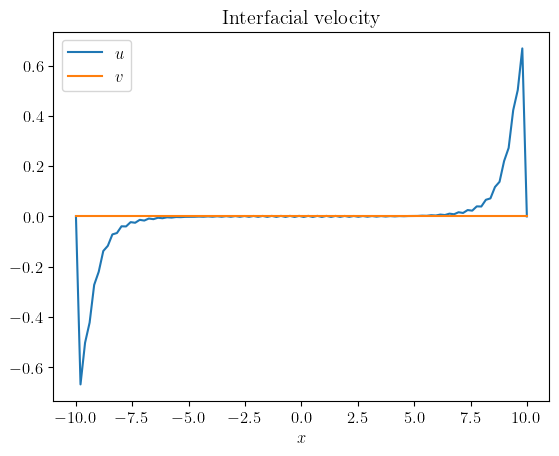

In [320]:
plt.plot(xx, uu[-1, :].real, label=r"$u$")
plt.plot(xx, vv[-1, :].real, label=r"$v$")
plt.title("Interfacial velocity")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

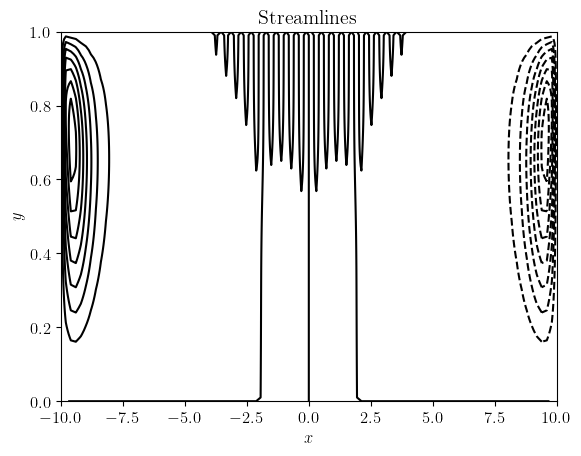

In [321]:
plt.contour(xx, yy, psii.real, levels=15, colors="black")
plt.title(r"Streamlines")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

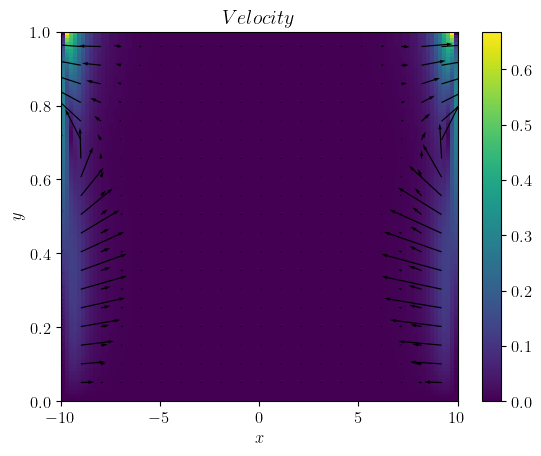

In [322]:
plt.quiver(xx[::step], yy[::step], uu[::step, ::step].real, vv[::step, ::step].real)

plt.imshow(np.sqrt(uu[::-1, :].real**2 + vv[::-1, :].real**2), extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()

plt.title(r"$Velocity$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

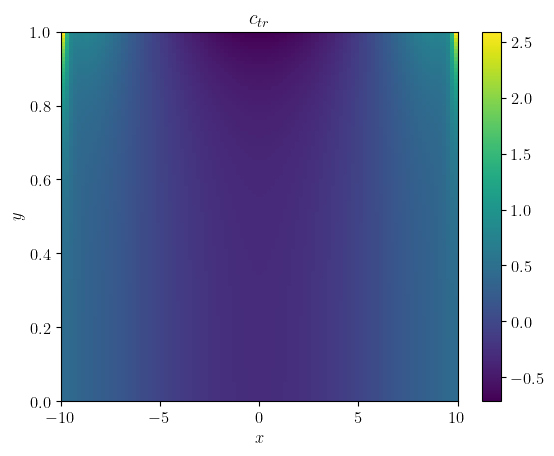

In [323]:
plt.imshow(cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tr}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

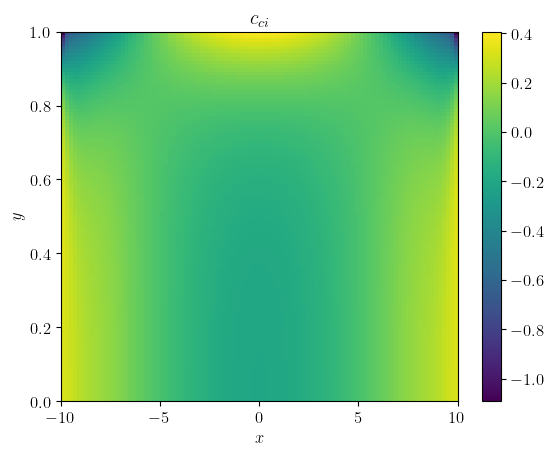

In [324]:
plt.imshow(cc_ci[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{ci}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

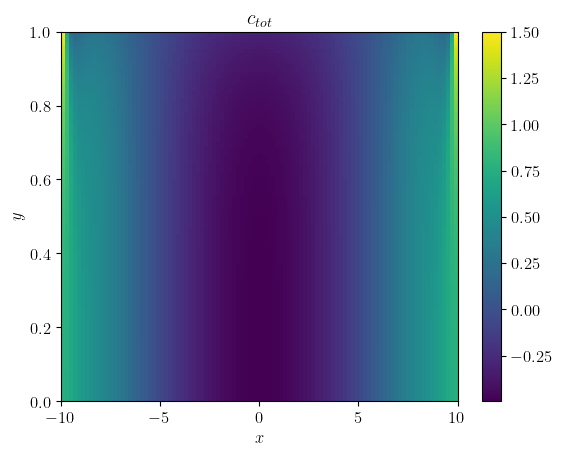

In [325]:
plt.imshow(cc_ci[::-1, :].real + cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tot}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

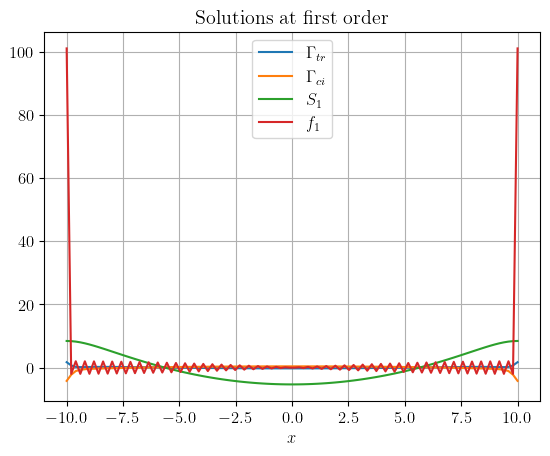

In [326]:
plt.plot(xx, ggamma_tr.real, label=r"$\Gamma_{tr}$")
plt.plot(xx, ggamma_ci.real, label=r"$\Gamma_{ci}$")
plt.plot(xx, SS_inv.real, label=r"$S_1$")
# plt.plot(xx, np.array([f_1(x) for x in xx]), label=r"$f_1$")  # Original light intensity
plt.plot(xx, ff_inv.real, label=r"$f_1$")  # Interpolated light intensity
plt.xlabel(r"$x$")
plt.title("Solutions at first order")
plt.legend()
plt.grid()
plt.show()

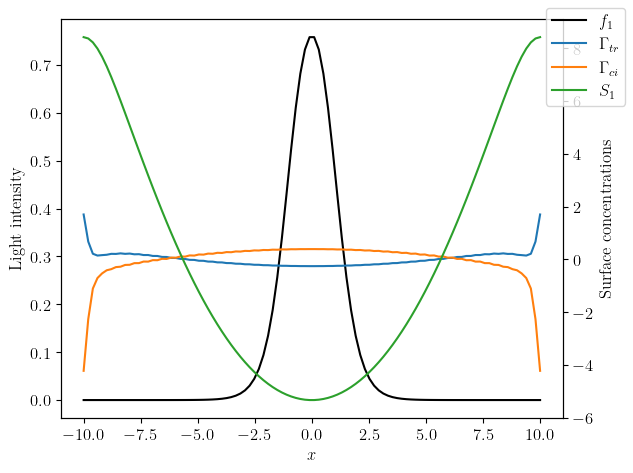

In [327]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(xx, ff.real, label=r"$f_1$", color="black")

ax2.plot(xx, ggamma_tr.real, label=r"$\Gamma_{tr}$")
ax2.plot(xx, ggamma_ci.real, label=r"$\Gamma_{ci}$")
ax2.plot(xx, SS_inv.real, label=r"$S_1$")

ax1.set_xlabel(r"$x$")
ax1.set_ylabel("Light intensity")
ax2.set_ylabel("Surface concentrations")

fig.legend()
fig.tight_layout()

fig.show()

### Inverse Problem Solution plots

#### Interfacial values

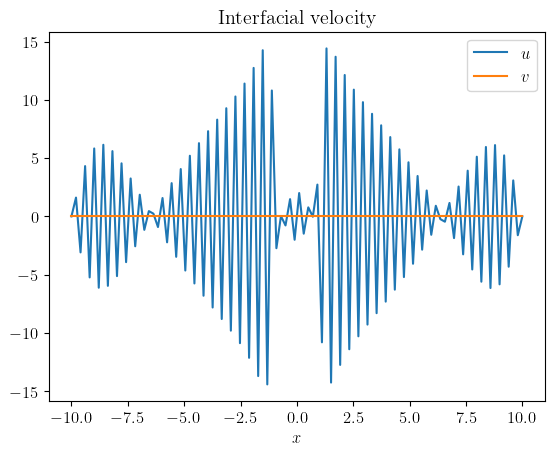

In [328]:
plt.plot(xx, inv_uu[-1, :].real, label=r"$u$")
plt.plot(xx, inv_vv[-1, :].real, label=r"$v$")
plt.title("Interfacial velocity")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

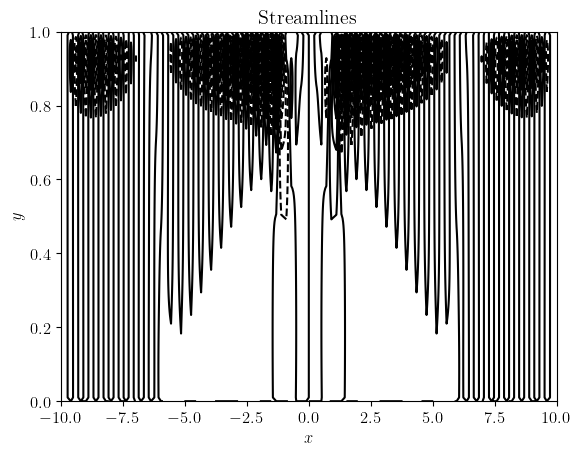

In [329]:
plt.contour(xx, yy, inv_psii.real, levels=15, colors="black")
plt.title(r"Streamlines")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

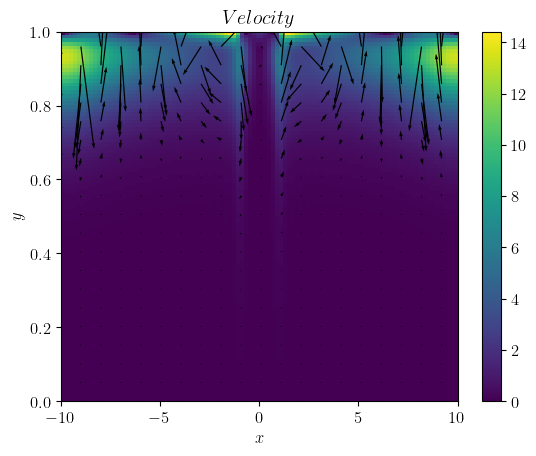

In [330]:
plt.quiver(xx[::step], yy[::step], inv_uu[::step, ::step].real, inv_vv[::step, ::step].real)

plt.imshow(np.sqrt(inv_uu[::-1, :].real**2 + inv_vv[::-1, :].real**2), extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()

plt.title(r"$Velocity$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

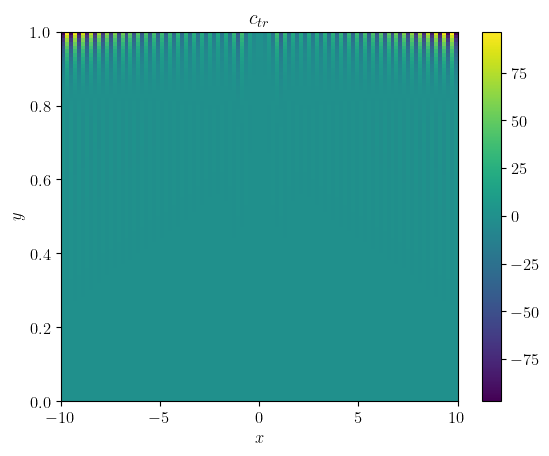

In [331]:
plt.imshow(inv_cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tr}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

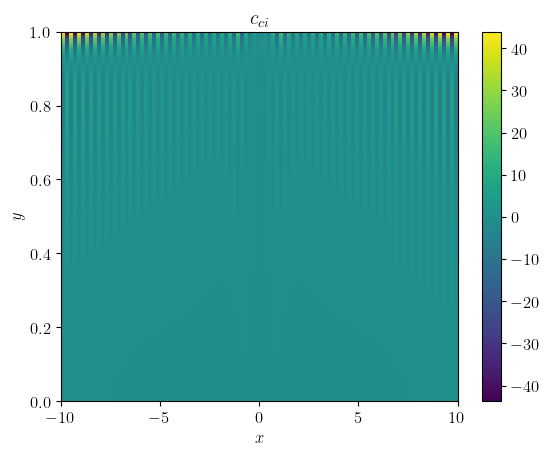

In [332]:
plt.imshow(inv_cc_ci[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{ci}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

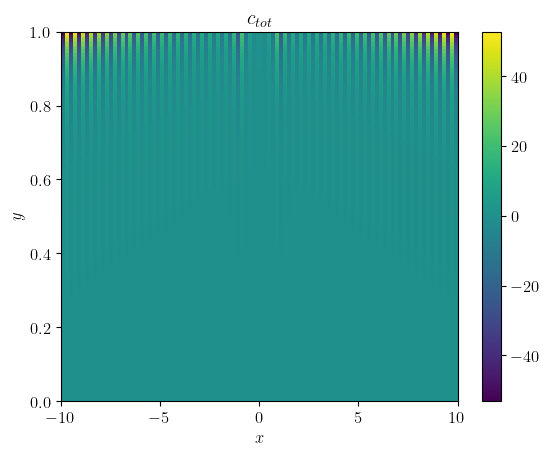

In [333]:
plt.imshow(inv_cc_ci[::-1, :].real + inv_cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tot}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

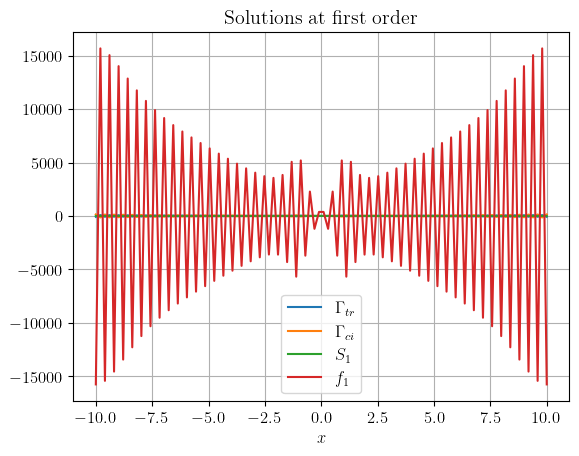

In [334]:
plt.plot(xx, inv_ggamma_tr.real, label=r"$\Gamma_{tr}$")
plt.plot(xx, inv_ggamma_ci.real, label=r"$\Gamma_{ci}$")
plt.plot(xx, inv_SS_inv.real, label=r"$S_1$")
# plt.plot(xx, np.array([f_1(x) for x in xx]), label=r"$f_1$")  # Original light intensity
plt.plot(xx, inv_ff_inv.real, label=r"$f_1$")  # Interpolated light intensity
plt.xlabel(r"$x$")
plt.title("Solutions at first order")
plt.legend()
plt.grid()
plt.show()

<class 'numpy.ndarray'>


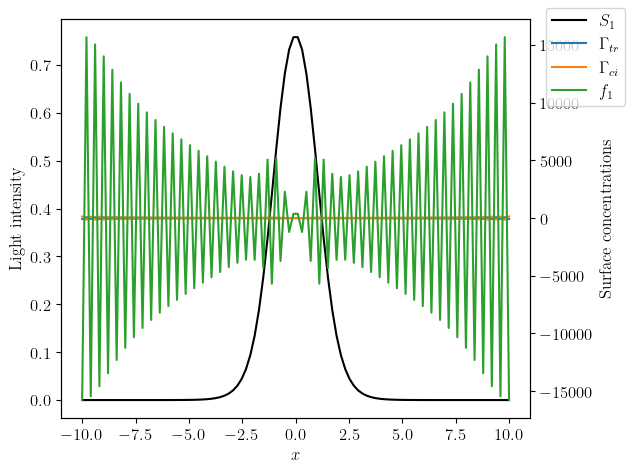

In [335]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

print(type(SS)) # Why is SS 1? Also why does S not look like it should?

ax1.plot(xx, SS.real, label=r"$S_1$", color="black")

ax2.plot(xx, inv_ggamma_tr.real, label=r"$\Gamma_{tr}$")
ax2.plot(xx, inv_ggamma_ci.real, label=r"$\Gamma_{ci}$")
ax2.plot(xx, inv_ff_inv.real, label=r"$f_1$")

ax1.set_xlabel(r"$x$")
ax1.set_ylabel("Light intensity")
ax2.set_ylabel("Surface concentrations")

fig.legend()
fig.tight_layout()

fig.show()

### General Solution

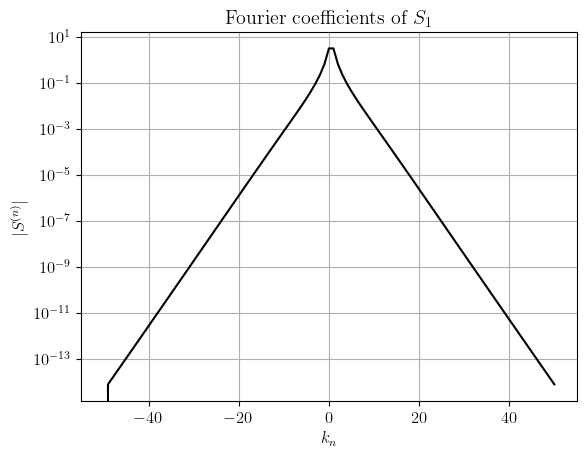

In [339]:
# plt.plot(omega_full, np.abs(S_f()), color="black")
plt.plot(np.arange(-N, N + 1), np.abs(S_f()), color="black")
plt.yscale("log")
plt.xlabel(r"$k_n$")
plt.ylabel(r"$|S^{(n)}|$")
plt.title(r"Fourier coefficients of $S_1$")
plt.grid()
plt.show()

### Testing